<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# PCA Lab: PCA Visualization and Horn's Parallel Analysis

_Author: Kiefer Katovich (SF)_

---

**Outline:**

- [Part I](#parti): Guided PCA Example with the [heptathlon performance dataset](./datasets/heptathlon.csv)
- [Part II](#partii): Try PCA yourself with the [wine quality dataset](./datasets/wine_quality.csv).
- [Part III](#partiii): Use Horn's Parallel Analysis to select the number of components.

**In this lab, we will:**

- Practice cleaning data.
- Perform PCA and interpret the principal components.
- Validate PCA results using visualizations and intuition.
- Select the number of PCs using elbow plots and Horn's Parallel Analysis.

_Horn's Parallel Analysis_ is a way to determine how many components you should keep after using a PCA on your data. Essentially, it will tell you which of your components are likely noise which can be discarded.


---

<a id="parti"></a>
# Part I: Heptathlon Dataset


### 1. Load packages and heptathlon data

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

plt.style.use('fivethirtyeight')

from ipywidgets import *
from IPython.display import display

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
# The athlete names make a natual index, and they are non-numeric
#   so no need to exclude them when making matrices
hep = pd.read_csv('../datasets/heptathlon.csv', index_col=0)

hep.head(3)

,hurdles,highjump,shot,run200m,longjump,javelin,run800m,score
Joyner-Kersee (USA),12.69,1.86,15.80,22.56,7.27,45.66,128.51,7291
John (GDR),12.85,1.80,16.23,23.65,6.71,42.56,126.12,6897
Behmer (GDR),13.20,1.83,14.20,23.10,6.68,44.54,124.20,6858


In [3]:
hep.shape

(25, 8)

---
#  
#  
### 2. Create dataframe excluding athlete and score

In [4]:
# Doublecheck the number of entries, number of null values, and proper data types
hep.info()

<class 'pandas.core.frame.DataFrame'>
Index: 25 entries, Joyner-Kersee (USA) to Launa (PNG)
Data columns (total 8 columns):
hurdles     25 non-null float64
highjump    25 non-null float64
shot        25 non-null float64
run200m     25 non-null float64
longjump    25 non-null float64
javelin     25 non-null float64
run800m     25 non-null float64
score       25 non-null int64
dtypes: float64(7), int64(1)
memory usage: 1.8+ KB


In [5]:
# Note that in some events, a high number is good whereas others it is bad.
# - javelin is distance thrown (higher is better)
# - shot is distance thrown (higher is better)
# - longjump is distance jumped (higher is better)


# PROBLEM: Running events are time taken (lower is better)
#   - So, we'll normalize to m/s   (higher is better)

hep['hurdles'] = 110. / hep['hurdles']
hep['run200m'] = 200. / hep['run200m']
hep['run800m'] = 800. / hep['run800m']

hep.head()

,hurdles,highjump,shot,run200m,longjump,javelin,run800m,score
Joyner-Kersee (USA),8.668243,1.86,15.80,8.865248,7.27,45.66,6.225196,7291
John (GDR),8.560311,1.80,16.23,8.456660,6.71,42.56,6.343165,6897
Behmer (GDR),8.333333,1.83,14.20,8.658009,6.68,44.54,6.441224,6858
Sablovskaite (URS),8.082292,1.80,15.23,8.361204,6.25,42.78,6.049607,6540
Choubenkova (URS),8.142117,1.74,14.76,8.357710,6.32,47.46,6.254887,6540


---
#  
#  
### 3. Examine the correlation between the different events

Plot a heatmap if you want to get fancy. What does the correlation matrix tell you?

In [6]:
hep.corr()

,hurdles,highjump,shot,run200m,longjump,javelin,run800m,score
hurdles,1.000000,0.779116,0.683805,0.802977,0.923797,0.043982,0.751634,0.934811
highjump,0.779116,1.000000,0.440786,0.473068,0.782442,0.002153,0.555286,0.767359
shot,0.683805,0.440786,1.000000,0.680184,0.743073,0.268989,0.447601,0.799699
run200m,0.802977,0.473068,0.680184,1.000000,0.814783,0.336934,0.633435,0.860900
longjump,0.923797,0.782442,0.743073,0.814783,1.000000,0.067108,0.697887,0.950437
javelin,0.043982,0.002153,0.268989,0.336934,0.067108,1.000000,0.025919,0.253147
run800m,0.751634,0.555286,0.447601,0.633435,0.697887,0.025919,1.000000,0.777813
score,0.934811,0.767359,0.799699,0.860900,0.950437,0.253147,0.777813,1.000000


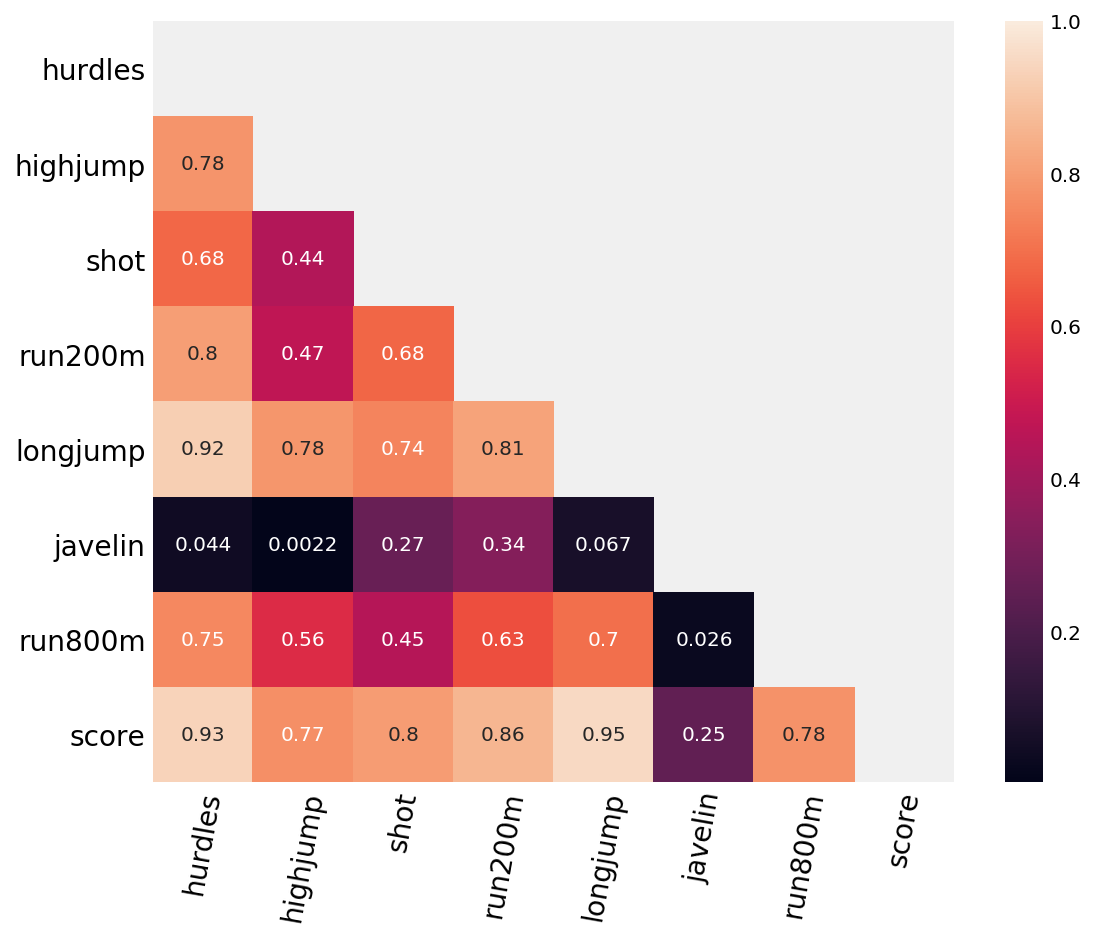

In [7]:
hep_corr = hep.corr()

mask = np.zeros_like(hep_corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

fig, ax = plt.subplots(figsize=(8,7))
ax = sns.heatmap(hep_corr, mask=mask, annot=True)

ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=14, rotation=80)
ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=14, rotation=0)

plt.show()

**Note all correlations are positive.** Why? 

Recall that we altered the data such that higher numbers always indicate a higher score and likely a better athlete overall.

---
#  
#  
### 4. Standardize the data

In [8]:
# Split into features and targets
#   - You can control the ordering of the event columns by changing their positions here

EVENT_NAMES = ['hurdles', 'run200m', 'run800m', 'highjump', 'shot', 'longjump', 'javelin']
TARGET_NAMES = ['score']

X = hep[EVENT_NAMES]
X.head()

,hurdles,run200m,run800m,highjump,shot,longjump,javelin
Joyner-Kersee (USA),8.668243,8.865248,6.225196,1.86,15.80,7.27,45.66
John (GDR),8.560311,8.456660,6.343165,1.80,16.23,6.71,42.56
Behmer (GDR),8.333333,8.658009,6.441224,1.83,14.20,6.68,44.54
Sablovskaite (URS),8.082292,8.361204,6.049607,1.80,15.23,6.25,42.78
Choubenkova (URS),8.142117,8.357710,6.254887,1.74,14.76,6.32,47.46


In [9]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
Xn = ss.fit_transform(X)     # X 'n'ormalized

---
#  
#  
### 5. Fit a PCA on the standardized data using sklearn

In [10]:
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(Xn)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [11]:
pca.components_

array([[-0.4537067 , -0.41103609, -0.37226083, -0.36742524, -0.36917476,
        -0.45596971, -0.08614954],
       [-0.13505313,  0.24712711, -0.17322253, -0.27633985,  0.25347623,
        -0.09221975,  0.86114134],
       [ 0.00846058, -0.09809294,  0.39876187,  0.41435647, -0.67952134,
        -0.11066596,  0.4308221 ],
       [ 0.01388192, -0.3166502 , -0.6411877 ,  0.65705272,  0.14288476,
         0.12238373,  0.14596634],
       [ 0.15563941,  0.64775707, -0.49459184, -0.06564944, -0.51893625,
         0.15926353, -0.11223419],
       [ 0.8317523 , -0.16327155, -0.11449967, -0.12923811,  0.00570046,
        -0.49834774,  0.05774845],
       [ 0.2441538 , -0.46242959, -0.05959757, -0.40523215, -0.21901407,
         0.69472805,  0.16783506]])

In [12]:
pc1_ev = pca.components_[0]

# Quick way of viewing, rather than looping through each feature
pd.Series(pc1_ev, index=EVENT_NAMES)

hurdles    -0.453707
run200m    -0.411036
run800m    -0.372261
highjump   -0.367425
shot       -0.369175
longjump   -0.455970
javelin    -0.086150
dtype: float64

In [13]:
pc2_ev = pca.components_[1]

pd.Series(pc2_ev, index=EVENT_NAMES)

hurdles    -0.135053
run200m     0.247127
run800m    -0.173223
highjump   -0.276340
shot        0.253476
longjump   -0.092220
javelin     0.861141
dtype: float64

---
#  
#  
### 6. Create a DataFrame with the principal components

Add back in the athelete and score columns from the original data.

In [14]:
pca.components_[0]

array([-0.4537067 , -0.41103609, -0.37226083, -0.36742524, -0.36917476,
       -0.45596971, -0.08614954])

In [15]:
hep_pcs = pca.transform(Xn)
hep_pcs = pd.DataFrame(hep_pcs, 
                       columns=['PC'+str(i+1) for i in range(len(EVENT_NAMES))],
                       index=hep.index)
hep_pcs['score'] = hep['score']
hep_pcs.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,score
Joyner-Kersee (USA),-4.400791,1.159007,-0.391943,0.055114,0.534981,-0.242880,0.358763,7291
John (GDR),-3.070295,0.449857,-0.901411,-0.521204,-0.714819,0.347712,0.133539,6897
Behmer (GDR),-2.828234,0.670888,0.508974,-0.786620,0.079807,-0.270952,-0.125716,6858
Sablovskaite (URS),-1.356669,0.668543,-0.635637,-0.081463,-0.471548,-0.033753,-0.502329,6540
Choubenkova (URS),-1.431348,1.818897,0.071717,-0.822202,-0.671438,0.127554,0.222916,6540


In [16]:
# Always make sure you verify as much as possible your numbers are correct!
#   - At the minimum, let's ensure the athletes and scores still match up
hep.head(2)

,hurdles,highjump,shot,run200m,longjump,javelin,run800m,score
Joyner-Kersee (USA),8.668243,1.86,15.80,8.865248,7.27,45.66,6.225196,7291
John (GDR),8.560311,1.80,16.23,8.456660,6.71,42.56,6.343165,6897


---
#  
#  
### 7. Plot the variance explained (ratio) of your components

Explain what this chart tells you about your components.

In [17]:
exp_var = pca.explained_variance_ratio_
exp_var

array([0.63832499, 0.16512568, 0.07267193, 0.06981022, 0.03691008,
       0.01029863, 0.00685847])

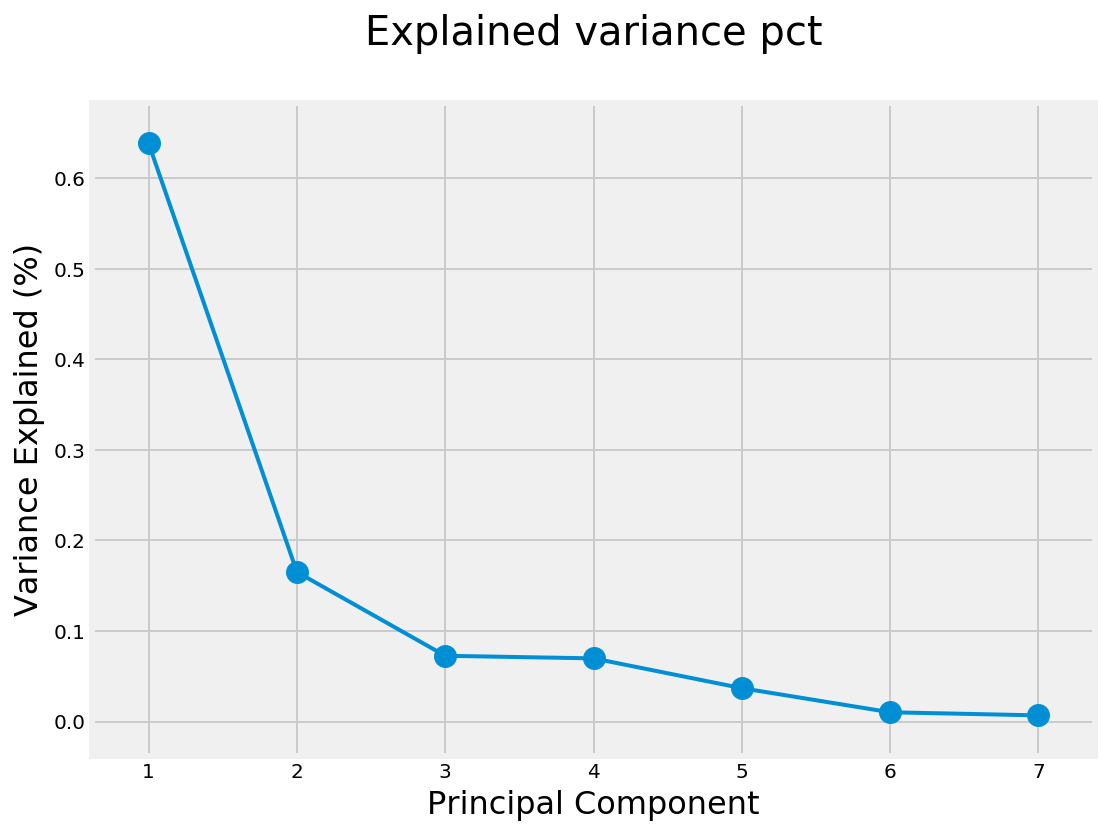

In [18]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(range(1, len(exp_var)+1), exp_var, lw=2)
ax.scatter(range(1, len(exp_var)+1), exp_var, s=120)
ax.set_title('Explained variance pct\n', fontsize=20)
ax.set_xlabel('Principal Component', fontsize=16)
ax.set_ylabel('Variance Explained (%)', fontsize=16)
plt.show()

Text(0,0.5,u'cumulative % of explained variance')

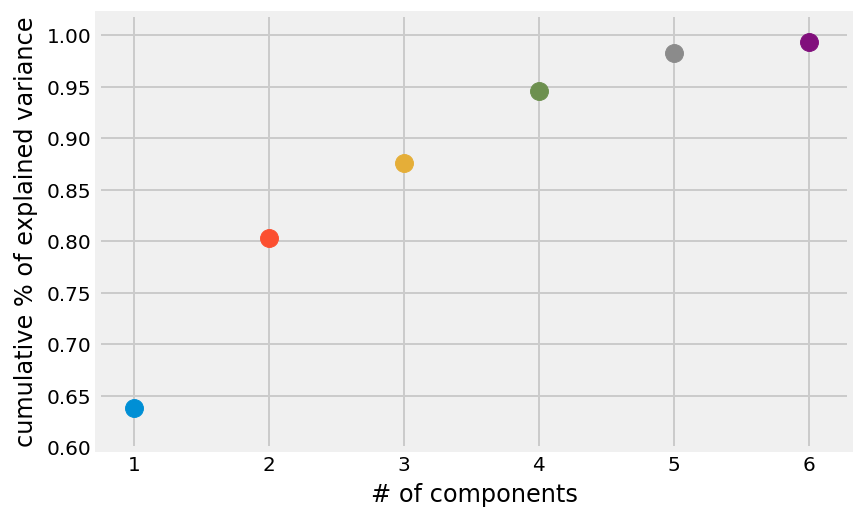

In [19]:
for i in range(1,len(pca.explained_variance_ratio_)):
    plt.scatter(i, sum(pca.explained_variance_ratio_[:i]), s=80)
plt.xlabel("# of components")
plt.ylabel('cumulative % of explained variance')

---
#  
#  
### 8. Print out the weights/eigenvectors (.components_ ) with their corresponding variables for PC1 and PC2

Based on how the original variables are weighted to calculate the components, how would you describe PC1 and PC2?

In [20]:
# Reminder of PC1 and PC2

pd.DataFrame({'PC1': pc1_ev, 'PC2': pc2_ev},
             index=EVENT_NAMES)

,PC1,PC2
hurdles,-0.453707,-0.135053
run200m,-0.411036,0.247127
run800m,-0.372261,-0.173223
highjump,-0.367425,-0.276340
shot,-0.369175,0.253476
longjump,-0.455970,-0.092220
javelin,-0.086150,0.861141


The first PC describes athletes who are below the mean in all categories. We will describe them as "below average".

The second PC describes athletes who are best at particularly javelin. We will describe them as "javelin".

---
#  
#  
### 9. Plot PC1 vs. PC2. Which athletes are notable on each component?

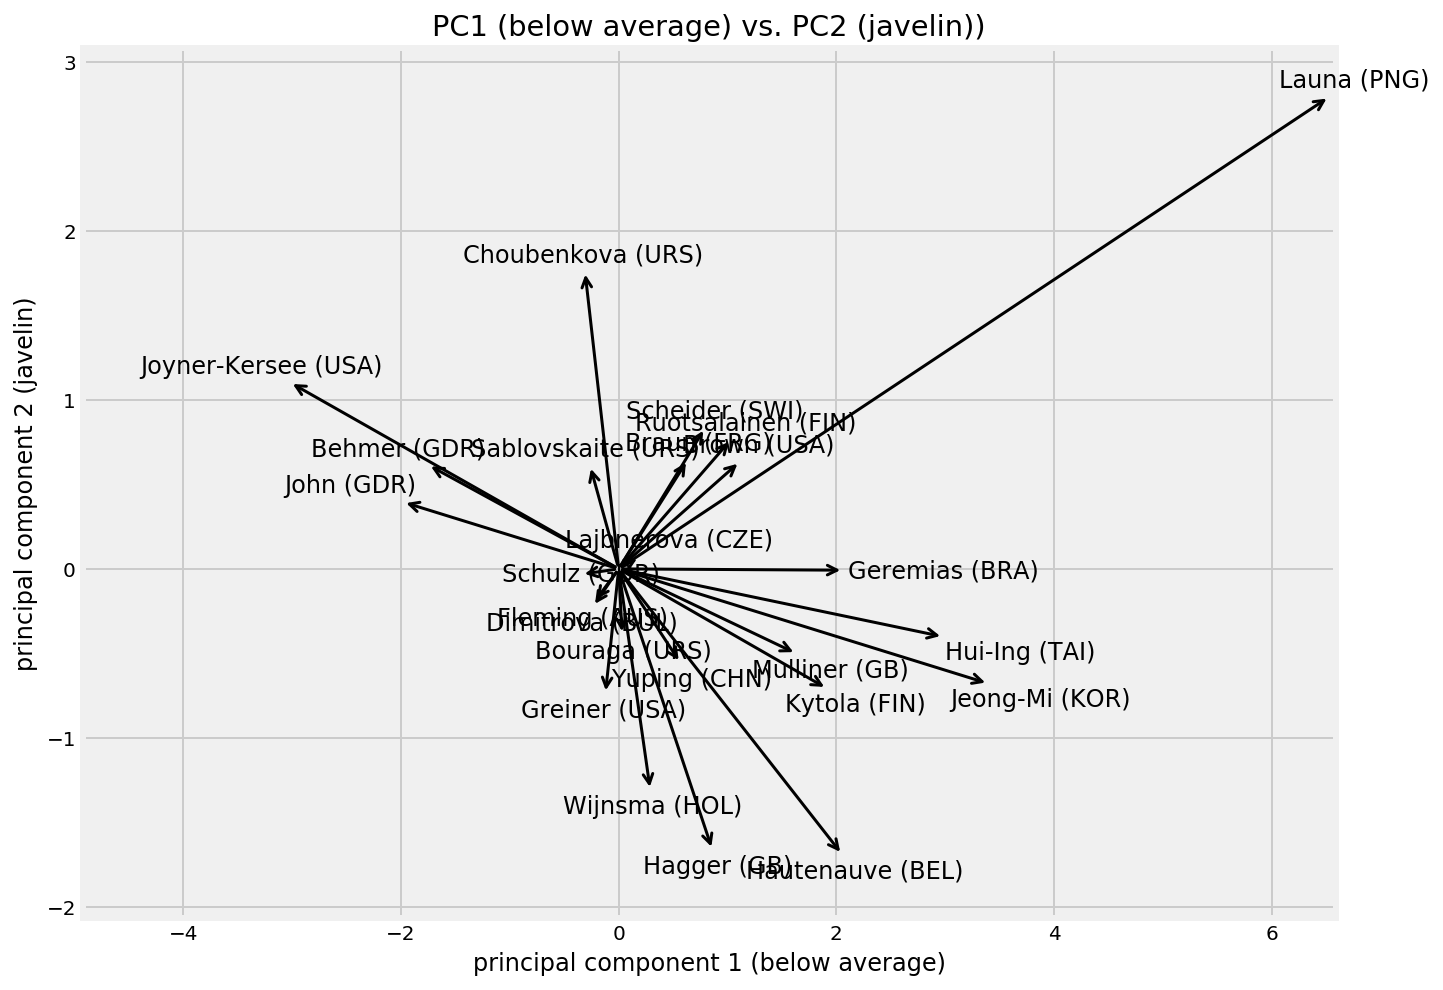

In [21]:
fig, ax = plt.subplots(figsize=(10,8))
ax.scatter(hep_pcs.PC1.values, hep_pcs.PC2.values, s=0)

for i, txt in enumerate(hep_pcs.index.values):
    ax.annotate(txt, (0, 0), (hep_pcs.PC1.values[i], hep_pcs.PC2.values[i]),
            arrowprops=dict(arrowstyle='<-', color='black', linewidth=1.5),
            xycoords='data', textcoords='data', fontsize=12, color="black")

ax.set_title('PC1 (below average) vs. PC2 (javelin))')
ax.set_xlabel('principal component 1 (below average)')
ax.set_ylabel('principal component 2 (javelin)')
plt.show()

---
#  
#  
### 10 (PC1). Plot PC1 vs. score. Do our results make sense?

Remember: **always interpret your results**. Because we claimed that PC1 described "below average" athletes, we would guess that a larger PC1 value would have a lower score.

Let's graph it below and see if the scores agree with our intuition!

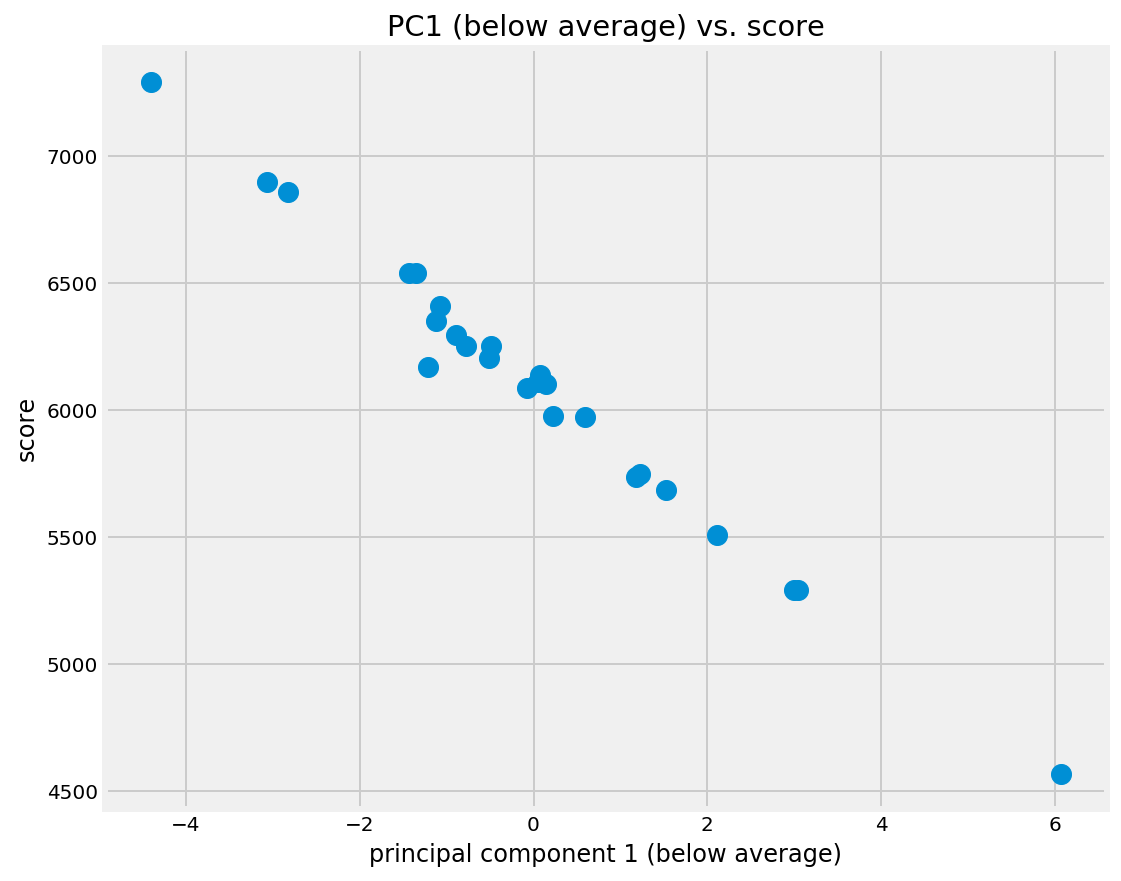

In [22]:
fig, ax = plt.subplots(figsize=(8,7))
ax.scatter(hep_pcs.PC1.values, hep_pcs.score.values, s=100)

ax.set_title('PC1 (below average) vs. score')
ax.set_xlabel('principal component 1 (below average)')
ax.set_ylabel('score')
plt.show()

**Does this graph agree with our guess above?** If not, then either our calculations or interpretation are likely incorrect! Thinking about the PCs allows us to provide evidence our results are correct -- and it helps us better understand the PCA results.

---
#  
#  
### 10 (PC2). Plot PC2 vs. score. What does this tell you about the relationship between the events and the score?

Again, consider how an athlete's score would be affected if he/she is better at javelin (our interpretation of PC2). After you understand how score _should be_ affected by PC2, look at the graph below. Does it agree with your expectation?

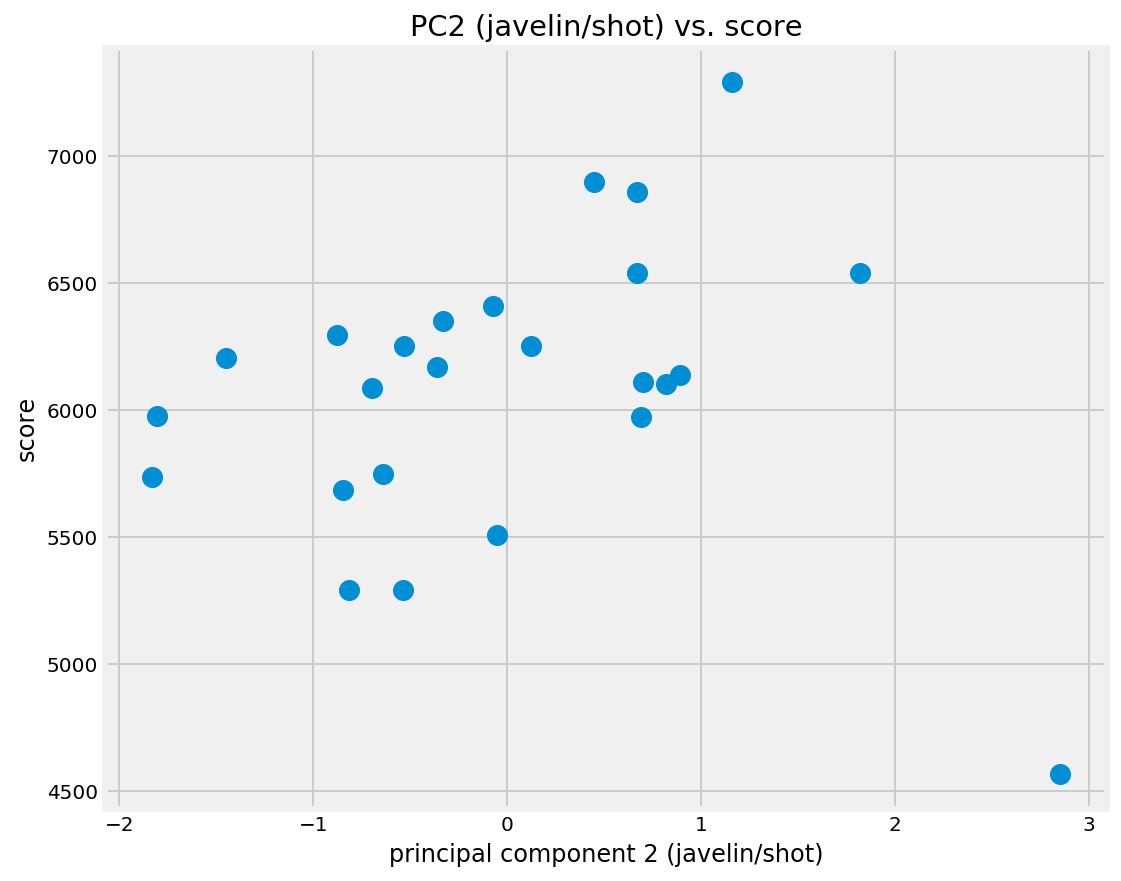

In [23]:
fig, ax = plt.subplots(figsize=(8,7))
ax.scatter(hep_pcs.PC2.values, hep_pcs.score.values, s=100)

ax.set_title('PC2 (javelin/shot) vs. score')
ax.set_xlabel('principal component 2 (javelin/shot)')
ax.set_ylabel('score')
plt.show()

**Tip:** Notice we have an outlier in the bottom right. Either outliers are genuine or bad data. It is typically useful to find the athlete corresponding to each outlier and determine if the data is bad.

---
#  
#  
<a id="partii"></a>
# Part II: Wine Quality Dataset

Now it's your turn! Try repeating the above analysis to investigate wine quality data. As much as possible, try to perform the analyses without looking above. Remember that most of the above is just manipulating Pandas data and plotting!


### 1. Load the wine data

In [24]:
wine = pd.read_csv('../datasets/wine_quality.csv')

wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,red_wine
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,1
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,1
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,1
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,1
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,1


In [25]:
wine.shape

(6497, 13)

---

### 2. Subset the wine data to everything except the `red_wine` column

In [26]:
WINE_TARGETS = ['red_wine']
WINE_FEATURES = list(set(wine.columns) - set(WINE_TARGETS))

wine_cont = wine[WINE_FEATURES]

---

### 3. Examine the correlation between variables

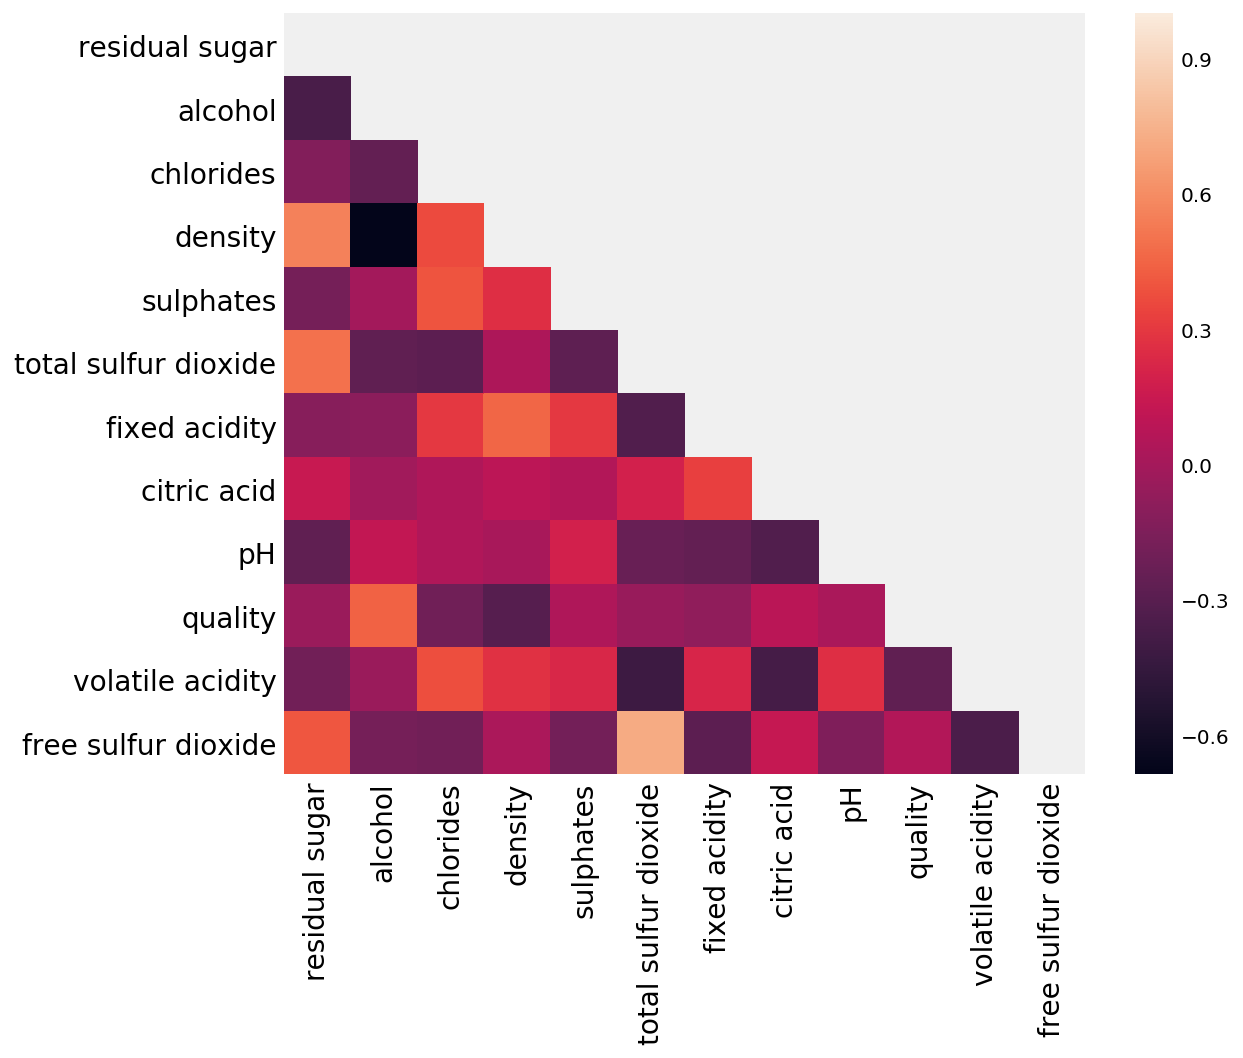

In [27]:
wine_corr = wine_cont.corr()

mask = np.zeros_like(wine_corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

fig, ax = plt.subplots(figsize=(8,7))
ax = sns.heatmap(wine_corr, mask=mask)

ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=14, rotation=90)
ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=14, rotation=0)

plt.show()

---

### 4. Standardize the variables

In [28]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
wine_cont_n = ss.fit_transform(wine_cont)

---

### 5. Fit a PCA on the standardized data

Create a new dataframe with the principal components and the `red_wine` column added back in from the original data.

In [29]:
from sklearn.decomposition import PCA

wine_pca = PCA().fit(wine_cont_n)

---

### 6. Create a DataFrame with the principal components

In [30]:
wine_pcs = wine_pca.transform(wine_cont_n)
wine_pcs = pd.DataFrame(wine_pcs, 
                        columns=['PC'+str(i) for i in range(1, wine_pcs.shape[1]+1)])

wine_pcs['red_wine'] = wine.red_wine

In [31]:
wine_pcs.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,red_wine
0,-3.348438,0.568926,-2.727386,-0.223777,0.621408,-0.231602,0.124851,-0.000515,-0.646268,-0.069141,-0.104249,0.027643,1
1,-3.228595,1.197335,-1.998904,-0.377154,0.110313,1.945885,0.938413,0.425532,-0.114802,-0.449160,-0.258251,-0.014469,1
2,-3.237468,0.952580,-1.746578,-0.472791,0.225404,1.082561,0.451976,0.411350,-0.120635,-0.272888,-0.081613,0.053961,1
3,-1.672561,1.600583,2.856552,-0.438364,0.213093,-0.970765,0.222429,-0.279690,-1.294900,0.212574,0.120527,-0.100574,1
4,-3.348438,0.568926,-2.727386,-0.223777,0.621408,-0.231602,0.124851,-0.000515,-0.646268,-0.069141,-0.104249,0.027643,1


---

### 7. Plot the variance explained ratio of the components

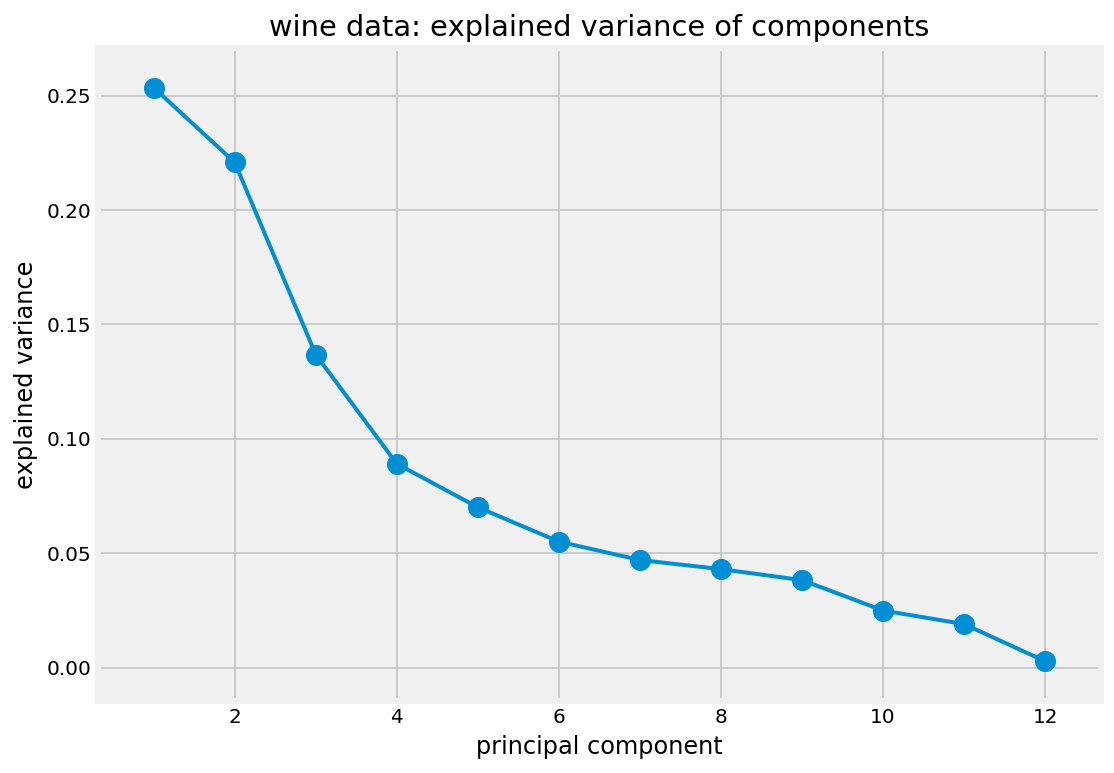

In [32]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(range(1, wine_cont.shape[1]+1), wine_pca.explained_variance_ratio_, lw=2)
ax.scatter(range(1, wine_cont.shape[1]+1), wine_pca.explained_variance_ratio_, s=100)
ax.set_title('wine data: explained variance of components')
ax.set_xlabel('principal component')
ax.set_ylabel('explained variance')
plt.show()

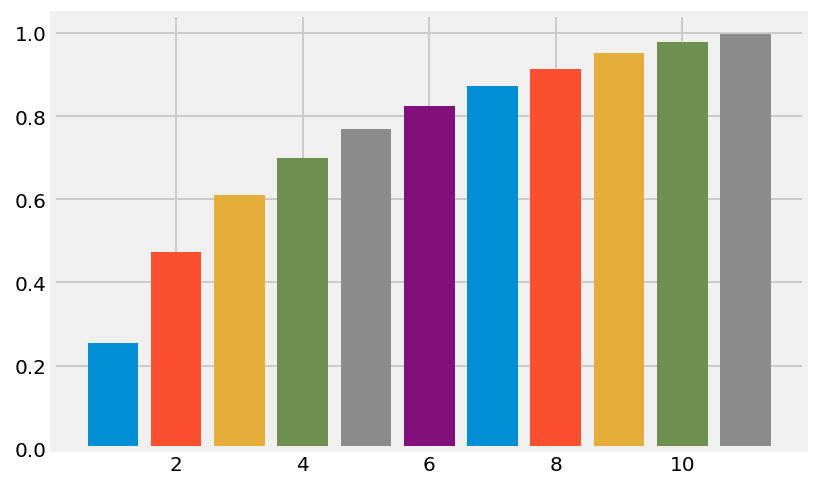

In [33]:
for i in range(1, len(wine_pca.explained_variance_ratio_)):
    plt.bar(i, sum(wine_pca.explained_variance_ratio_[:i]))

---

### 8. Print out the component weights with their corresponding variables for PC1, PC2, and PC3

How would you label the components based on the weights?

In [34]:
pd.Series(wine_pca.components_[0], index=wine_cont.columns)

residual sugar          0.318905
alcohol                -0.058924
chlorides              -0.313450
density                -0.092438
sulphates              -0.299852
total sulfur dioxide    0.474420
fixed acidity          -0.256929
citric acid             0.146461
pH                     -0.208070
quality                 0.087476
volatile acidity       -0.394931
free sulfur dioxide     0.422691
dtype: float64

**Note:** It is interesting to research what causes these factors in wines. For example, is SO2 added to wine, or is it a natural byproduct of ingredients? What affects how much SO2 a winemaker might add to wine? By researching these questions, you can likely find a good explanation for these PCs -- beyond a bland description of the weightings. You can also use these intuitions from research (e.g. how pH and residual sugar affect SO2) to provide evidence of the PC validity.

In [35]:
pd.Series(wine_pca.components_[1], index=wine_cont.columns)

residual sugar          0.342585
alcohol                -0.492727
chlorides               0.269770
density                 0.554920
sulphates               0.119634
total sulfur dioxide    0.143948
fixed acidity           0.261843
citric acid             0.144093
pH                     -0.152922
quality                -0.296601
volatile acidity        0.105198
free sulfur dioxide     0.111179
dtype: float64

In [36]:
pd.Series(wine_pca.components_[2], index=wine_cont.columns)

residual sugar         -0.075502
alcohol                 0.212931
chlorides               0.046769
density                -0.051563
sulphates               0.168691
total sulfur dioxide   -0.101281
fixed acidity           0.467486
citric acid             0.588076
pH                     -0.406787
quality                 0.295838
volatile acidity       -0.279689
free sulfur dioxide    -0.098998
dtype: float64

---

### 9. Plot PC1 vs. PC2.

- Use a regular scatterplot.
- Vary the alpha value to see better densities.

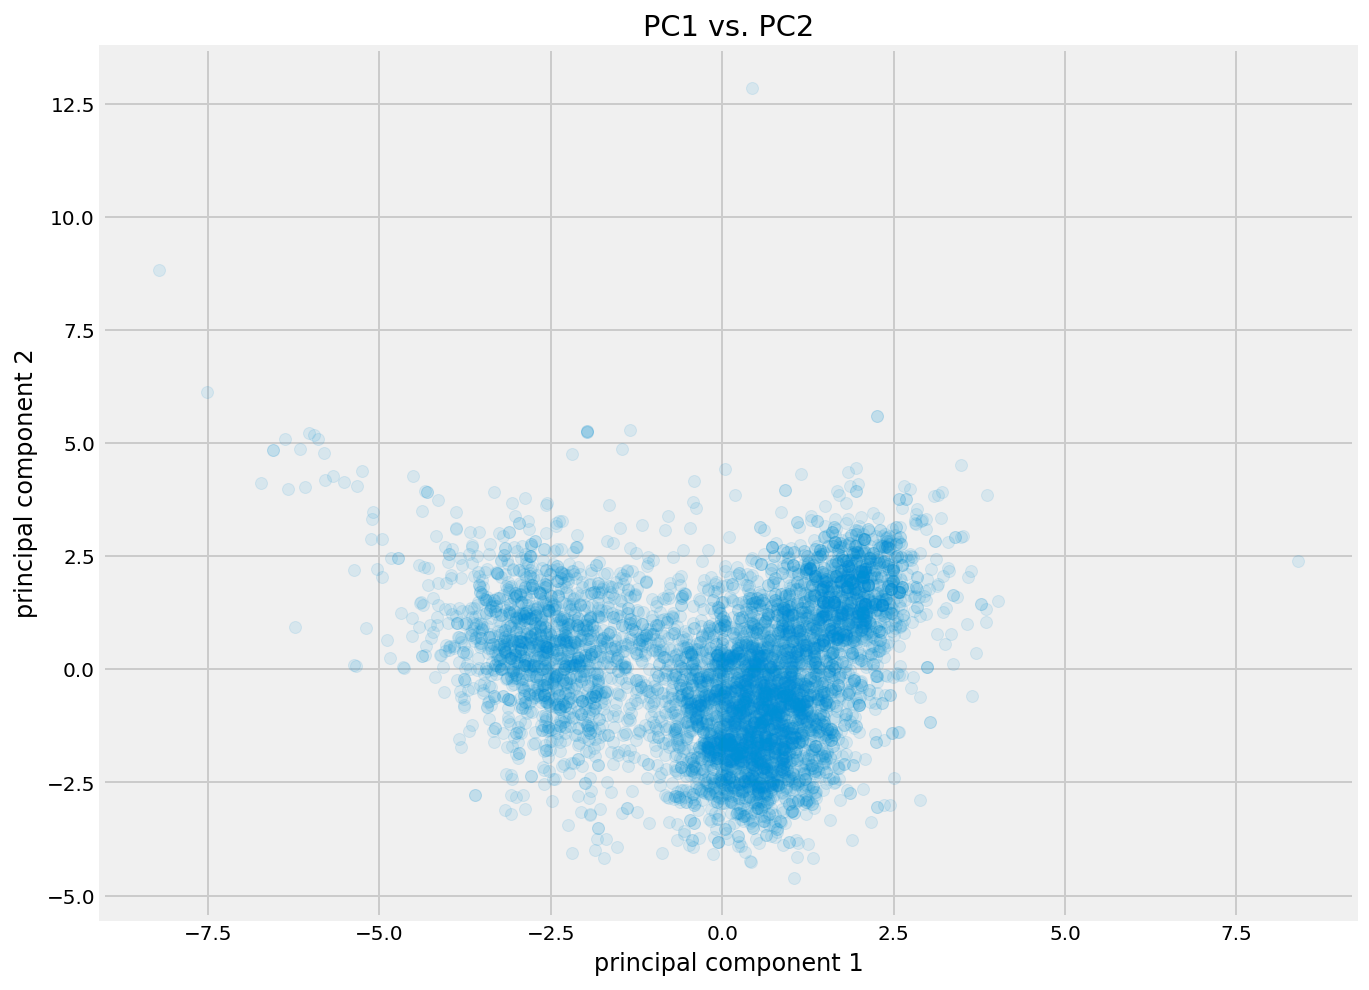

In [37]:
fig, ax = plt.subplots(figsize=(10,8))
ax.scatter(wine_pcs.PC1.values, wine_pcs.PC2.values, alpha=0.1)

ax.set_title('PC1 vs. PC2')
ax.set_xlabel('principal component 1')
ax.set_ylabel('principal component 2')
plt.show()

---

### 10. Plot a seaborn pairplot of PC1, PC2, and PC3 with `hue='red_wine'`

Do any of the components differentiate red and white wine? If so, what does this tell you about the difference between red and white wine based on the component weights? Does each plot align with your expectation based on the components?

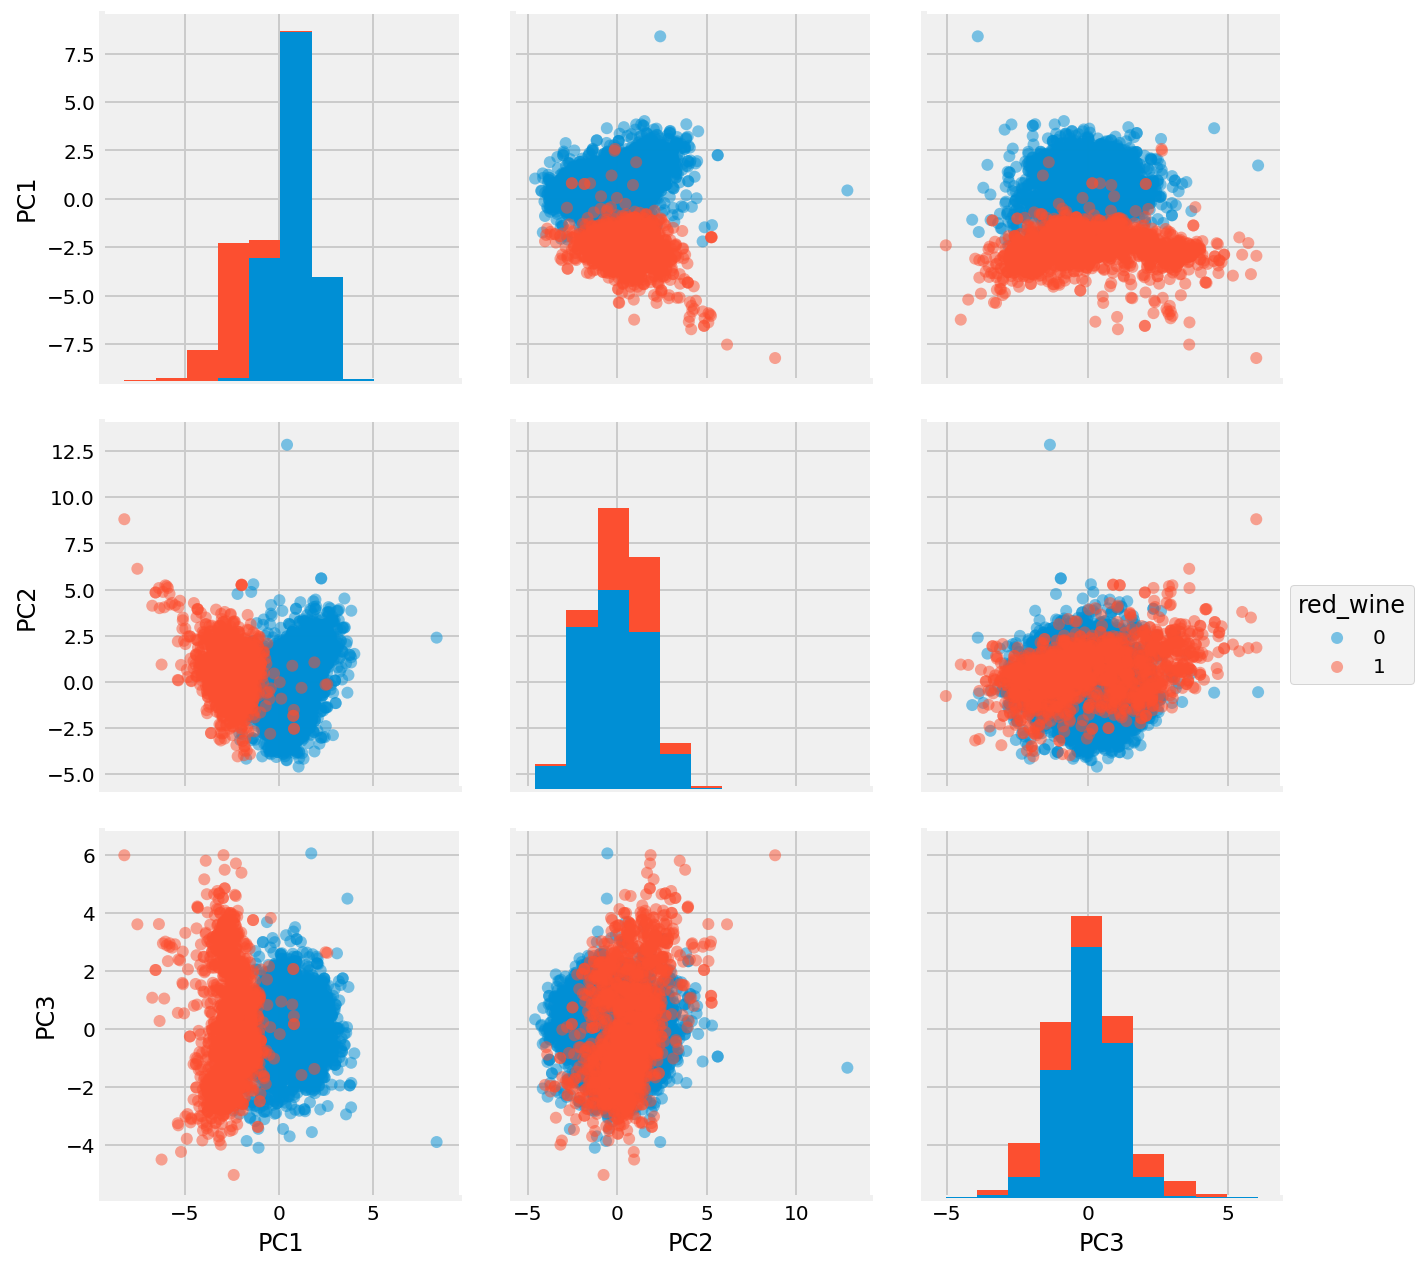

In [38]:
sns.pairplot(data=wine_pcs, 
             vars=['PC1','PC2','PC3'], 
             hue='red_wine', 
             size=3,
             plot_kws={'edgecolor':'None',
                       'alpha':0.5});

---
#  
#  
<a id="partiii"></a>
# Part III: Horn's parallel analysis

You can determine the appropriate number of components to keep by using a bootstrapping procedure known as Horn's Parallel Analysis. This is (as far as I know) the gold standard in determining which components aren't noise.

How to do the parallel analysis (pseudocode):

    for n iterations:
        create normally distributed random data the same shape as your data
        fit a PCA on the random data
        pull out the eigenvalues
    select a percentile of the eigenvalues as your threshold (0.5 = median, 0.95 = 95% confidence, etc.)
    plot the random component eigenvalues at that percentile against your data's pca eigenvalues
    components above the selected percentile are not noise, those under are
   
Ultimately, we are comparing the PCA explained variance of YOUR DATASET against the PCA explained variance of random Gaussians! If your PCA's explained variance is lower than that of random Gaussians, then we will assume these components likely represent noise.

--- 

### 1. Write a function to perform the parallel analysis.

In [39]:
def horn_parallel_analysis(shape, iters=1000, percentile=95):
    pca = PCA(n_components=shape[1])
    eigenvals = []
    
    for i in range(iters):
        rdata = np.random.normal(0,1,size=shape)
        pca.fit(rdata)
        eigenvals.append(pca.explained_variance_)
    
    eigenvals = np.array(eigenvals)
    return np.percentile(eigenvals, percentile, axis=0)

---

### 2. Run parallel analysis for the heptathlon data

In [40]:
hep_pa = horn_parallel_analysis(X.shape, percentile=95)
hep_pa

array([2.52042218, 1.8627695 , 1.47099632, 1.14768779, 0.87522989,
       0.65230834, 0.44272422])

### 3. Run parallel analysis for the wine data

In [41]:
wine_pa = horn_parallel_analysis(wine_cont.shape, percentile=95)
wine_pa

array([1.09502281, 1.071879  , 1.05584667, 1.04210943, 1.03041086,
       1.017897  , 1.00665569, 0.99480912, 0.98340677, 0.97215507,
       0.95812617, 0.94327589])

---

### 4. Plot the wine eigenvalues (`.variance_explained_`) against the parallel analysis random eigenvalue cutoffs

How many components are not noise, based on the chart?

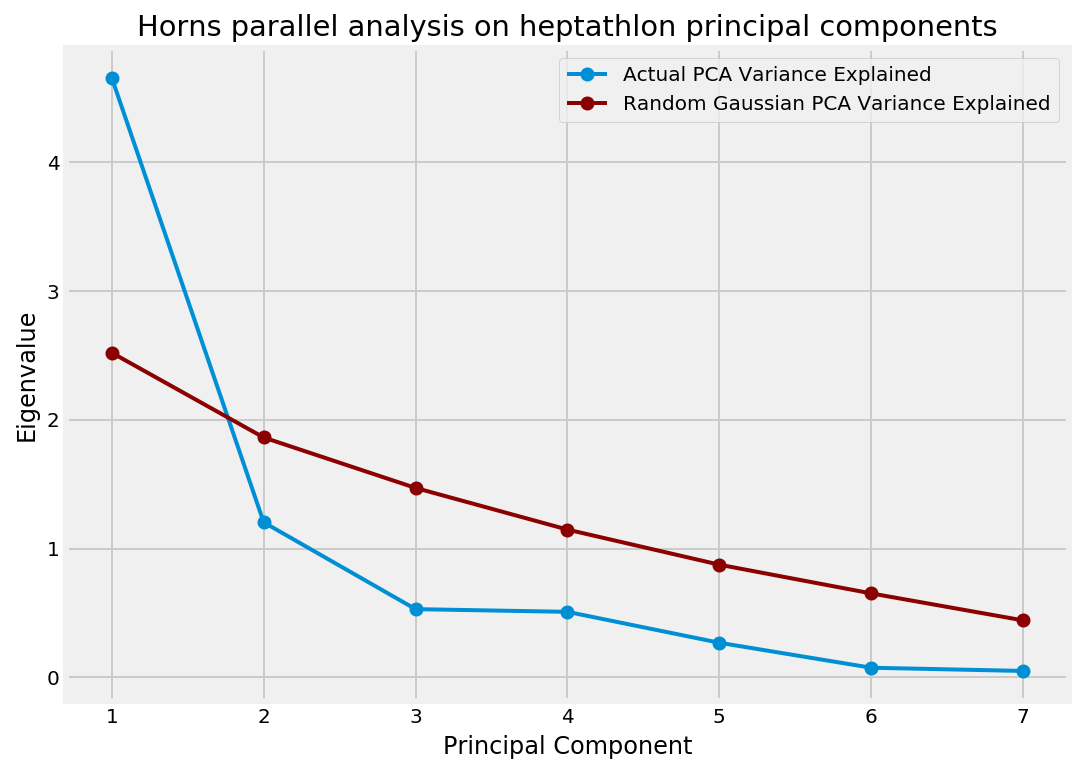

In [42]:
fig, ax = plt.subplots(figsize=(8,6))

ax.plot(range(1, X.shape[1]+1), pca.explained_variance_, lw=2, marker='o')
ax.plot(range(1, X.shape[1]+1), hep_pa, lw=2, color='darkred', marker='o')

ax.set_title("Horns parallel analysis on heptathlon principal components")
ax.set_xlabel("Principal Component")
ax.set_ylabel("Eigenvalue")

plt.legend(['Actual PCA Variance Explained', "Random Gaussian PCA Variance Explained"])
plt.show()

**Conclusion:** Note the ACTUAL variance explained is lower than the variance explained of the random gaussian variance after PC #1. Hence, a reasonable set of PCs would just be the first.

---

### 5. Plot the Wine eigenvalues (`.variance_explained_`) against the parallel analysis random eigenvalue cutoffs

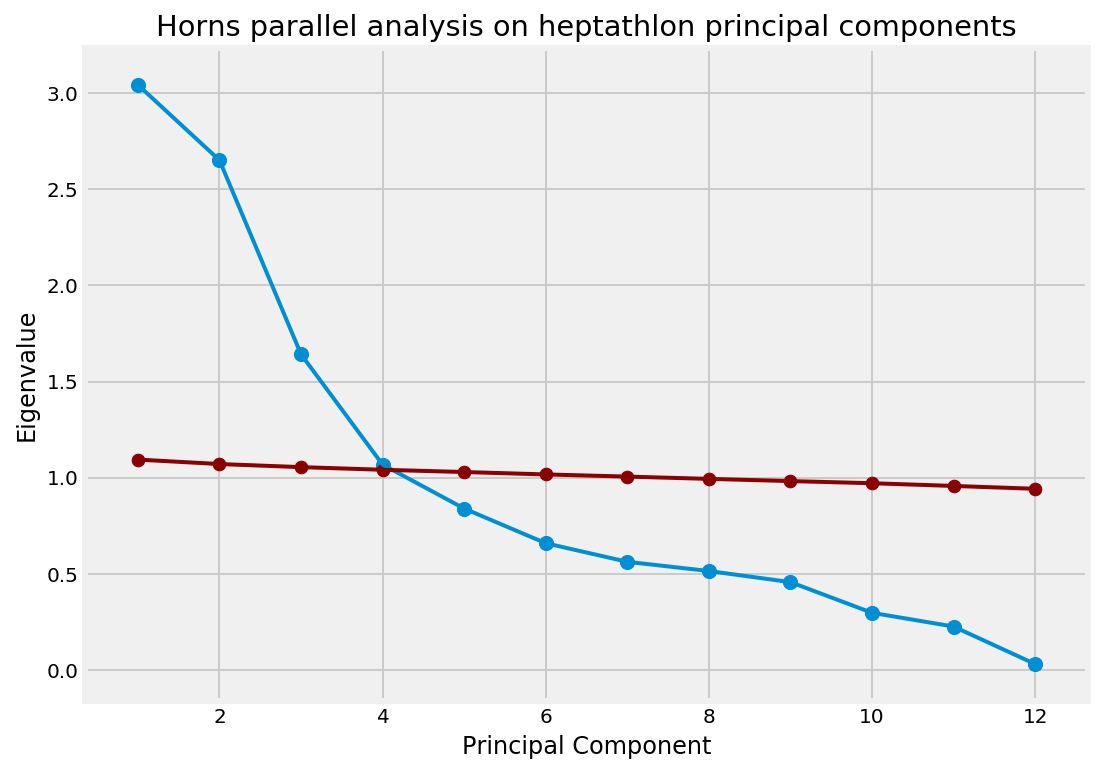

In [43]:
fig, ax = plt.subplots(figsize=(8,6))

ax.plot(range(1, wine_cont.shape[1]+1), wine_pca.explained_variance_, lw=2)
ax.scatter(range(1, wine_cont.shape[1]+1), wine_pca.explained_variance_, s=50)

ax.plot(range(1, len(wine_pa)+1), wine_pa, lw=2, color='darkred')
ax.scatter(range(1, len(wine_pa)+1), wine_pa, s=40, color='darkred')


ax.set_title("Horns parallel analysis on heptathlon principal components")
ax.set_xlabel("Principal Component")
ax.set_ylabel("Eigenvalue")
plt.show()